In [2]:
import os
# Disable tokenizers parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [3]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 7.7 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


In [14]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from torch.cuda import amp
from transformers import AutoModel, AutoTokenizer,AutoConfig
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
import torch
import warnings
from sklearn.model_selection import StratifiedKFold
import random
warnings.filterwarnings('ignore')
from collections import defaultdict
import torch.nn as nn
from transformers import get_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from collections import defaultdict
import gc
gc.enable()

In [5]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

In [6]:
splits = {'train': 'cleaned_train.csv', 'val': 'cleaned_val.csv'}
train_df = pd.read_csv("hf://datasets/kcrl/Shared_Task_Fake_News/" + splits["train"])
val_df = pd.read_csv("hf://datasets/kcrl/Shared_Task_Fake_News/" + splits["val"])

In [7]:
with pd.option_context('display.max_colwidth',0):
    display(train_df.sample(n=10))

,text,label
2181,avaru thannayanu rogam vitathu enitu marunu kandupidichu matum pinna a marunu mattula rajiyangangale velpeshum,Fake
648,ഇത് സെൽഫ് ട്രോൾ ആണോ.,original
1067,"ഞാൻ ഒന്ന് ചോദിച്ചോട്ടെ. ഇവരെ ഇങ്ങനെ അധിക്ഷേപിക്കാൻ ima യും<br>മരുന്ന് ലോബികളും താങ്കൾക്കും ചാനലിനും എന്ത് വിലയിട്ടൂ.<br><br>ഇവരുടെ ചികിത്സയിൽ മരിച്ചവരുടെ കണക്ക് എടുക്കാൻ എളുപ്പമാണ്, ഒന്നോ രണ്ടോ ഇൗ കഴിഞ്ഞ 5 വർഷത്തിൽ ഉണ്ടാകും, എന്നാല് അതിന് പകരം ഇവർ ചികിത്സിച്ച് ഭേദമാക്കിയവരുടെ കണക്കെടുത്താൽ, നിങ്ങൾക്ക് പണം വാരി തരുന്ന അലോപ്പതി ഡോക്ടർമാർ കൊന്നതിന്റെ കണക്ക് കിട്ടും.<br>നല്ല ആഹാരം, നല്ല ശ്വസനം, സ്വന്തം കൃഷി ചെയ്ത് വീട്ടിൽ ഉണ്ടാക്കി കഴിക്കണം എന്ന് പറയുന്നതോ, ഇല്ലാത്ത രോഗത്തിന് മാറാത്ത മരുന്ന് കൊടുത്ത് ഇഞ്ച് ഇഞ്ചാ യി കൊല്ലുന്നതാണോ കുറ്റകരം.<br><br>നമ്മൾ ദിവസവും കഴിക്കുന്ന എല്ലാ ഭക്ഷ്യവസ്തുക്കളും അലോപ്പതി മരുന്നും ചികിത്സയും മായമാണ് എന്ന് പറയുന്നത്, രാജ്യത്തെ ലൂസിഫർ മാർക്കും അവരുടെ എച്ചിൽ നക്കുന്ന പത്ര മാധ്യമങ്ങൾക്കു സഹിക്കാൻ പറ്റില്ല. മോഹനന് വൈദ്യ രും, dr jecob vadakkancheriyum ഇല്ലത്തവേണ്ടത്, ജനങ്ങളുടെ ആവശ്യമേ അല്ല. ഇവിടത്തെ മരുന്ന് മാഫിയകൾക്ക് മാത്രമാണ്.<br><br>എല്ലാക്കാലവും നിങ്ങൾക്ക് ഇവരെ കല്ലെറിയാൻ കഴിയില്ല, സത്യം പുറത്ത് വരും. ഇന്നല്ലെങ്കിൽ നാളെ. കരുതി ഇരുന്നോ.",Fake
716,ennitu pravasikalude mele corantain,original
1543,made in china,Fake
249,തിരുവാതിര ഒരു കലാരൂപം ആണെന്ന് ആണ് ഞാൻ വിചാരിച്ചതു.അപ്പോൾ ഇനി ഭാരതനാട്യതിന് പുഷ്പ മൂവിലെ സോങ്‌സ് പരിഗണിക്കണം. കേരളം ലേജിക്കുന്നു,original
1409,10 varsham munpe rtpcr testu chaithalum 10 varsham kazhinhu rtpcr chaithalum innu corona ennu pottanmmar vilikkunna ie virusente saanidhyam kaanaam?,Fake
1463,മണി ചെയിൻ തട്ടിപ്പാണെന്നു സർക്കാർ പറഞ്ഞാൽ വിവരമില്ലാത്തവർ കേൾക്കില്ല അത് പോലെയാണ് ഇതും അനുഭവിക്കുമ്പോൾ പഠിക്കും,Fake
3199,keralathil undaya munamathe durantham,Fake
2108,ഞങ്ങൾ തിരുവാതിര കളിക്കും. ബേബി ചിരിക്കും,original


In [8]:
with pd.option_context('display.max_colwidth',0):
    display(val_df.sample(n=5))

,text,label
53,korona എവിടെയും പോയിട്ടില്ല ഉടനെ ഒന്നും പോവുകയും ഇല്ല ഇന്ത്യയിൽ തന്നെ ഇനി വരുന്ന രണ്ട് മൂന്നു മാസത്തിനുള്ളിൽ ലക്ഷങ്ങൾ രോഗികൾ ആവും എന്നത് യാഥാർഥ്യം ആണ് അതുപോലെ അമേരിക്ക ബ്രസീൽ ഇവിടെ ഒക്കെ രോഗം വർധിക്കാൻ സാധ്യത ഉണ്ട് യൂറോപ്പ്യൻ രാജ്യങ്ങളിൽ വ്യാപനം കുറഞ്ഞിട്ടുണ്ട് എങ്കിലും വീണ്ടും ഒരു രണ്ടാം വരവ് തള്ളികളയാൻ ആവില്ല തണുപ് കൂടുന്നതോടെ രോഗം തിരിച്ചു വന്നേക്കാം ഇപ്പൊ ഒട്ടും ആശ്വസിക്കാൻ ആയിട്ടില്ല ചിലപ്പോൾ ഇപ്പോഴതിനേക്കാൾ ശക്തമായ ഒരു തിരിച്ചുവരവ് europil ഉണ്ടാവും പൂർണമായും ഈ വൈറസ് ഇല്ലാതെ ആവും എന്ന് കരുതാൻ വയ്യ,Fake
597,evamarude sadanam aarum medikaruthu dhushttanmar. evanmare othukkanam,Fake
503,najagaluda. orukunju. vaccine. adutha. shesham. marichu. poy,Fake
651,india lm community spread undayillalo ennorth nammak ashwasikkam,Fake
108,whatapp messages athupole vayikkuvano,Fake


In [9]:
train_df.label.unique()

array(['Fake', 'original'], dtype=object)

In [10]:
labeling = {
    'Fake': 0,
    'original': 1
}
train_df['label'] = train_df['label'].apply(lambda x : labeling[x])
val_df['label'] = val_df['label'].apply(lambda x : labeling[x])

In [11]:
with pd.option_context('display.max_colwidth',0):
    display(train_df.sample(n=5))

,text,label
2417,north korea &amp; russia know how to use medicin on corona patients. 10 മിനിറ്റിൽ എല്ലാം ശരിയാക്കും,0
2098,"കമൻറ് ബോക്സിൽ മൊത്തം പരാതി ഒരു കമ്മിയെ പോലും കണ്ടില്ല,ന്യായീകരിക്കാൻ.",1
1616,കൊറോണ. ഓടി രക്ഷപ്പെട്ടു<br><br>ഗം. ദി ബെസ്റ്റ് പ്രോഗ്രാം,1
291,stupidity at its peak,1
1039,china ഉണ്ടാക്കിയ biological weapon അല്ലെ . അപ്പോൾ അതിന്റെ മറുമരുന്നും അവർ കണ്ടുപിടിച്ചതിനു ശേഷം virus തുറന്നു വിട്ടു അത്ര തന്നെ .ചൈന ആയിട്ട് നല്ല ബന്ധം ഉള്ള റഷ്യക്ക് ചൈന മറുമരുന്ന് കൊടുത്തു വീട്ടുകാണും,0


In [12]:
with pd.option_context('display.max_colwidth',0):
    display(val_df.sample(n=5))

,text,label
415,കേരളത്തിലെ ഈ ദുരന്തങ്ങൾക്കെല്ലാം കാരണം ഈ ഭൂതം ഒരുത്തൻ മാത്രമാണ്.,1
426,ഇജ്ജാതി പാർട്ടി.,1
646,എന്റെ കൂട്ടിക്കലത്ത് ആരോ പറഞ്ഞു കേട്ടിട്ടുണ്ട് ലോകം മൊത്തം നശിച്ചാലും 10 ചയിനക്കാർ ജീവിക്കാൻ സാധ്യതയുണ്ട് എന്ന്. ഇത് ഇപ്പോൾ സതൃമായി വരുകയാണോ?,0
765,ഞമ്മന്റെ ആളായത്കൊണ്ട് കൊഴപ്പമില്ല ആരും ഉച്ചപ്പാടിനടക്കില്ല ഇവിടെ വേറെ വെല്ലോരും ആണേൽ കാണായിരുന്നു,0
39,communust chathikkuja thanne cheyyum,0


In [13]:
class Config:
    NUM_EPOCHS = 15
    NUM_FOLDS = 10
    BATCH_SIZE = 32
    MODEL_PATH = "FacebookAI/xlm-roberta-base"
    LR = 2e-5
    DROPOUT = 0.3
    NUM_CLASSES = 2
    SEED = 42
    MAX_LEN = 130
    DEVICE =  "cuda" if torch.cuda.is_available() else "cpu"

config  = Config()

In [20]:
train_df.loc[:, 'kfold'] = -1
train_df = train_df.sample(frac=1).reset_index(drop=True)

kfold = StratifiedKFold(n_splits=config.NUM_FOLDS, random_state=config.SEED, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df, train_df['label'])):
    train_df.loc[val_idx, "kfold"] = fold
train_df.to_csv("train_data_folds.csv", index=False)

In [21]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_PATH)

<Axes: ylabel='Count'>

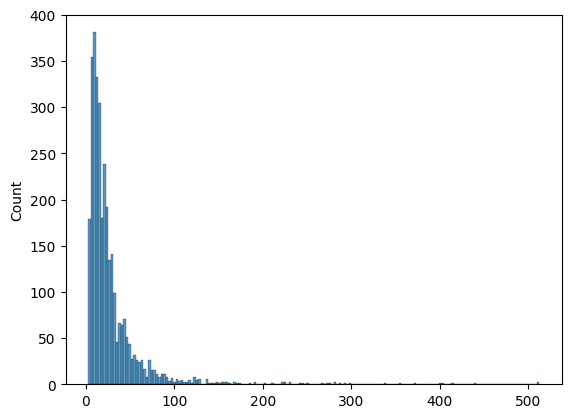

In [22]:
token_counts = []

for _, row in train_df.iterrows():
    text = str(row["text"])  # Ensure the text is converted to a string
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)

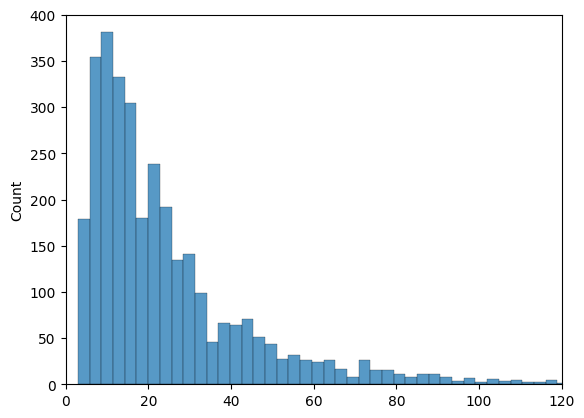

In [23]:
sns.histplot(token_counts)
plt.xlim([0, 120]);

<Axes: ylabel='Count'>

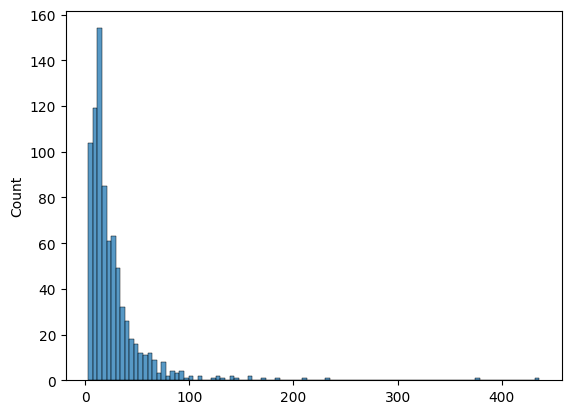

In [24]:
token_counts = []

for _, row in val_df.iterrows():
    text = str(row["text"])  # Ensure the text is converted to a string
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)

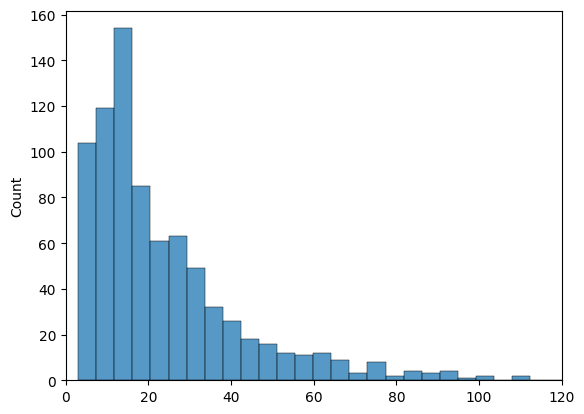

In [25]:
sns.histplot(token_counts)
plt.xlim([0, 120]);

In [26]:
class ClassifierDataset(Dataset):
    def __init__(self, df,tokenizer):
        super(ClassifierDataset, self).__init__()
        self.df = df 
        self.labels = torch.tensor(df.label.values, dtype=torch.long)
        self.tokenizer = tokenizer
        self.max_length = config.MAX_LEN

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.iloc[index]["text"])
        inputs = self.tokenizer(
            text,
            padding=True, 
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        labels = self.labels[index]

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

In [28]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [29]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super(ClassifierModel,self).__init__()
        self.model_config = AutoConfig.from_pretrained(config.MODEL_PATH)
        self.model = AutoModel.from_pretrained(config.MODEL_PATH,config = self.model_config)
        # Adjusting input size for three pooling methods
        self.dense = torch.nn.Linear(self.model_config.hidden_size * 3, self.model_config.hidden_size)
        self.dropout = torch.nn.Dropout(config.DROPOUT)
        self.classifier = nn.Linear(self.model_config.hidden_size, config.NUM_CLASSES)
        
    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids,attention_mask=attention_mask)
        last_hidden_state = output[0]
        
        # CLS token
        cls_token = last_hidden_state[:,0,:]
        
        # Mean pooling
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        
        # Max pooling
        last_hidden_state[input_mask_expanded == 0] = -1e9 
        max_embeddings = torch.max(last_hidden_state, 1)[0]
        
        # Concatenate all three embeddings
        pooled = torch.cat((cls_token, mean_embeddings, max_embeddings), 1)
        pooler = self.dense(pooled)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [30]:
class Engine:
    def __init__(self, model, optimizer,scheduler = None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    @staticmethod
    def loss_fn(target, pred):
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(pred,target)
        return loss
    
    @staticmethod
    def compute_metrics(labels, pred):
        y_true = labels.cpu().numpy()
        pred = pred.cpu().numpy()
        y_pred = np.argmax(pred, axis = -1)
        f1 = f1_score(y_true, y_pred, average='macro')
        return f1
        
    def train(self, train_dataloader,scaler,num_training_steps):
        self.model.train()
        total_training_loss = 0.0
        progress_bar = tqdm(range(num_training_steps))
        for data in train_dataloader:
            input_ids = data["input_ids"].to(config.DEVICE)
            attention_mask = data["attention_mask"].to(config.DEVICE)            
            target = data["labels"].to(config.DEVICE)
            self.optimizer.zero_grad()
            
            with amp.autocast():
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                
            total_training_loss += loss.item()
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()
            if self.scheduler:
                self.scheduler.step()
            progress_bar.update(1)
                
        return total_training_loss / len(train_dataloader)
    
    def evaluate(self,eval_dataloader):
        self.model.eval()
        val_loss = 0
        score = 0.0
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                input_ids = data["input_ids"].to(config.DEVICE)  
                attention_mask = data["attention_mask"].to(config.DEVICE)              
                target = data["labels"].to(config.DEVICE)  
                
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                val_loss += loss.item()
                batch_score = self.compute_metrics(target,pred)
                score+= batch_score
             
            score = score / len(eval_dataloader)
            val_loss = val_loss / len(eval_dataloader)
        
        return score, val_loss

In [35]:
def run_training(fold, save_model = False):
    
    train_data = train_df[train_df.kfold != fold].reset_index(drop = True)
    val_data = train_df[train_df.kfold == fold].reset_index(drop = True)
    
    train_dataset = ClassifierDataset(train_data, tokenizer)    
    val_dataset = ClassifierDataset(val_data, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size = config.BATCH_SIZE,
                               shuffle =True, collate_fn = data_collator,num_workers=2)    
    val_loader = DataLoader(val_dataset, batch_size = config.BATCH_SIZE,
                            drop_last=False, shuffle=False,  collate_fn=data_collator, num_workers=2)   
    set_random_seed(config.SEED + fold)
    model = ClassifierModel()
    model.to(config.DEVICE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr= 2e-5, weight_decay=0.01)
    num_training_steps = config.NUM_EPOCHS * len(train_loader)
    scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
    )
    eng = Engine(model, optimizer, scheduler)
    scaler = amp.GradScaler()
    early_stopping_iter = 5
    early_stopping_counter = 0
    best_score = 0.0
    print(f"Fold: {fold + 1}")
    for epoch in range(config.NUM_EPOCHS):
        train_loss = eng.train(train_loader,scaler,num_training_steps)
        val_score,val_loss = eng.evaluate(val_loader)
        
        print(f"Epoch: {epoch + 1} | Training_loss: {round(train_loss,5)} | Validation_loss: {round(val_loss,5)} | Score: {round(val_score,5)}")
        
        if val_score > best_score:
            best_score = val_score
            early_stopping_counter = 0
            
            if save_model:
                torch.save(model.state_dict(),f"model_{fold}.bin")
        else:
            early_stopping_counter +=1
            
        if early_stopping_counter > early_stopping_iter:
            break
            
    del model
    gc.collect()
            
    return best_score

In [ ]:
all_scores = []
for fold in range(config.NUM_FOLDS):
    temp_score =run_training(fold,save_model = True)
    all_scores.append(temp_score)

    print(f"Fold score:{temp_score}")

print(f"overall Score: {np.mean(all_scores)}")

In [ ]:
# model = ClassifierModel()
# model_path = f"/kaggle/working/best_model.bin"
# model.load_state_dict(torch.load(model_path))

In [ ]:
# model.to(config.DEVICE)

In [ ]:
# test_dataset = ClassifierDataset(val_df, tokenizer)

In [ ]:
# from torch.utils.data import DataLoader
# test_dataloader = DataLoader(
#     test_dataset, batch_size=64, collate_fn=data_collator
# )

In [ ]:
# model.eval()
# pred = []
# for batch in test_dataloader:
#     batch = {k: v.to(config.DEVICE) for k, v in batch.items()}
#     with torch.no_grad():
#         outputs = model(input_ids = batch["input_ids"],attention_mask = batch["attention_mask"])
#         batch_preds = torch.argmax(outputs, dim=-1)
#         pred.extend(batch_preds.cpu().numpy().tolist()) 

In [ ]:
# y_true = val_df.label.values
# y_pred = pred

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# print(confusion_matrix(y_true, y_pred))

In [ ]:
# from sklearn.metrics import (
#     classification_report,
#     confusion_matrix,
#     f1_score,
#     accuracy_score,
#     precision_score,
#     recall_score
# )

# # Print the classification report
# print("Classification Report:\n", classification_report(y_true, y_pred))

# # Print the confusion matrix
# print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# # Calculate individual metrics for weighted and macro averages
# weighted_f1 = f1_score(y_true, y_pred, average='weighted')
# macro_f1 = f1_score(y_true, y_pred, average='macro')

# weighted_precision = precision_score(y_true, y_pred, average='weighted')
# macro_precision = precision_score(y_true, y_pred, average='macro')

# weighted_recall = recall_score(y_true, y_pred, average='weighted')
# macro_recall = recall_score(y_true, y_pred, average='macro')

# accuracy = accuracy_score(y_true, y_pred)

# # Print metrics
# print("Weighted F1 Score:", weighted_f1)
# print("Macro F1 Score:", macro_f1)
# print("Weighted Precision:", weighted_precision)
# print("Macro Precision:", macro_precision)
# print("Weighted Recall:", weighted_recall)
# print("Macro Recall:", macro_recall)
# print("Accuracy:", accuracy)

In [ ]:
# import torch
# import matplotlib.pyplot as plt
# from mlxtend.plotting import plot_confusion_matrix
# from torchmetrics import ConfusionMatrix
# y_pred = torch.tensor(y_pred)
# y_true = torch.tensor(y_true)

# cmat = ConfusionMatrix(task="multiclass", num_classes=2)
# confusion_matrix = cmat(y_pred, y_true)

# fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.cpu().numpy(),
#                                 class_names=[0,1],
#                                 colorbar=True)

# # Rotate the x-axis labels
# plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# # Show the plot
# plt.show()